In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Gradient Tape -> For Automatic Differentiation
x=tf.Variable(3.0,trainable=True)
with tf.GradientTape() as g:
  g.watch(x)
  y=x*2+x*x
print(g.gradient(y,x).numpy())

8.0


In [3]:
x=tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  with tf.GradientTape() as gg:
    gg.watch(x)
    y=x * x
  dy_dx=gg.gradient(y, x)     
d2y_dx2=g.gradient(dy_dx, x)  

print(dy_dx)
print(d2y_dx2)

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [4]:
# gradient w.r.t multiple variables
x=tf.constant(3.0)
y=tf.constant(4.0)
with tf.GradientTape(persistent=True) as g:  # use persistent=True for multiple calls
  g.watch(x)
  g.watch(y)
  z=y * y + x * x
dz_dx_dy=g.gradient(z, [x,y])  

print(x)
print(y)
print(dz_dx_dy)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>, <tf.Tensor: shape=(), dtype=float32, numpy=8.0>]


In [5]:
(xtrain,ytrain),(_,_)=keras.datasets.mnist.load_data()
print(xtrain.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [6]:
# Normalize the data b/w -1 to +1
xtrain=xtrain.reshape(xtrain.shape[0],28,28,1).astype('float32')

xtrain=(xtrain-127.5)/127.5

In [7]:
print(xtrain.shape)

(60000, 28, 28, 1)


In [8]:
# Convert train_images into a tf.data.Dataset 
BUFFER_SIZE=60000
BATCH_SIZE=256

train_dataset=tf.data.Dataset.from_tensor_slices(xtrain).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [9]:
# this model arch is copied from tensorflow which best for mnist dataset
def make_generator_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    
    # assert is used to debug
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5),strides=(1, 1),padding='same',use_bias=False))
    assert model.output_shape==(None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

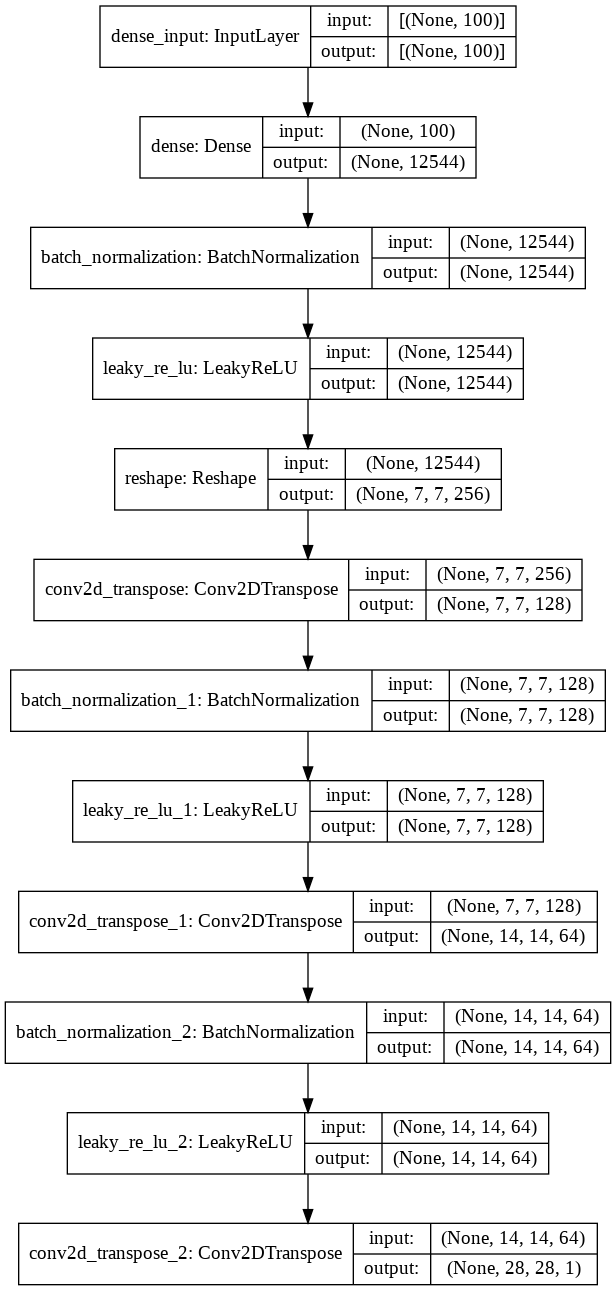

In [10]:
generator=make_generator_model()
keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

In [11]:
noise=tf.random.normal([1,100])
generator_img=generator(noise,training=True)

In [12]:
print(generator_img.shape)

(1, 28, 28, 1)


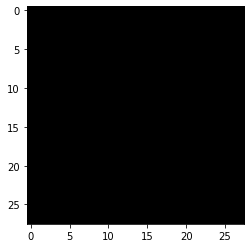

In [13]:
plt.imshow(generator_img[0,:,:,0],cmap='gray',interpolation='nearest')

In [14]:
# refrenced from tensflow documentation
def make_discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

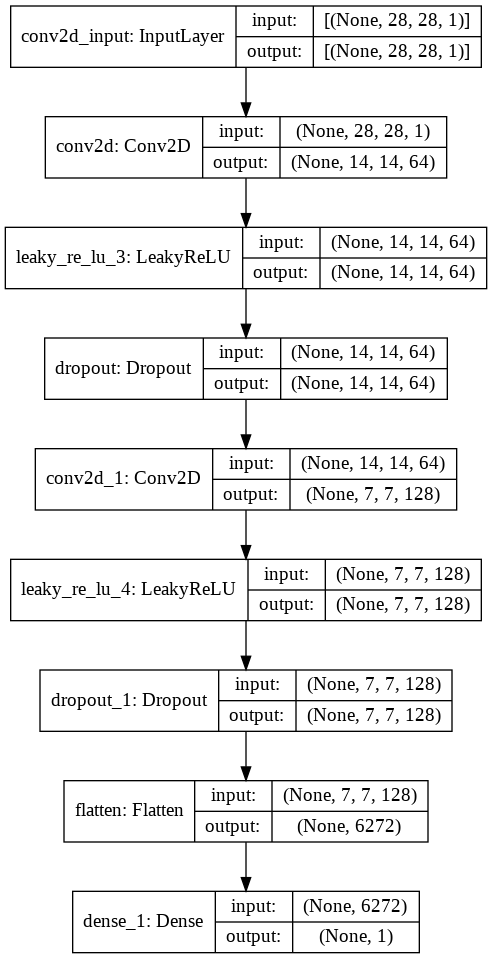

In [15]:
discriminator=make_discriminator_model()
keras.utils.plot_model(discriminator, 'discriminator.png', show_shapes=True)

In [16]:
decision=discriminator(generator_img) # forward-pass. model not yet trained
print (decision)

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


In [27]:
# Loss: BCE-> log-loss
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output), real_output) 
    fake_loss=cross_entropy(tf.zeros_like(fake_output), fake_output) 
    total_loss=real_loss+fake_loss
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

test_random_vectors = tf.random.normal([num_examples_to_generate, noise_dim])
print(test_random_vectors.shape)

(16, 100)


In [31]:
@tf.function # use this before function t0 compile func in tf graph comput'lly
def train_step(images):
    noise=tf.random.normal([BATCH_SIZE,noise_dim])

    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
      generated_images=generator(noise,training=True)

      real_output=discriminator(images, training=True)
      fake_output=discriminator(generated_images,training=True)

      gen_loss=generator_loss(fake_output)
      disc_loss=discriminator_loss(real_output,fake_output)

    gradients_of_generator=gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator=disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [32]:
def generate_and_save_images(model, epoch, test_input):
  # training is set to False.
  predictions=model(test_input, training=False)
  fig=plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray') 
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [38]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)
    generate_and_save_images(generator,
                             epoch + 1,
                             test_random_vectors)

  generate_and_save_images(generator,
                           epochs,
                           test_random_vectors)

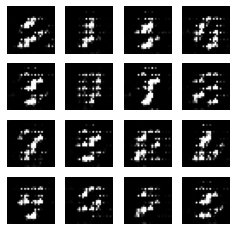

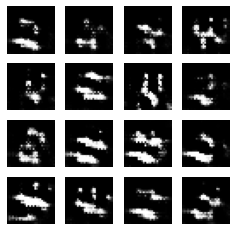

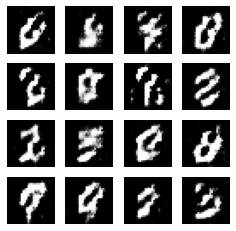

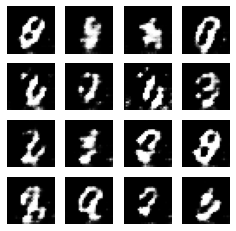

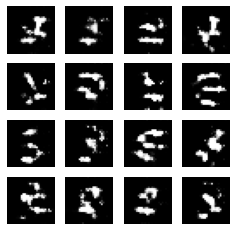

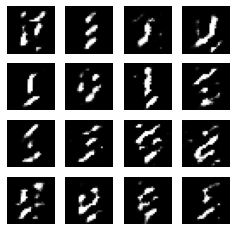

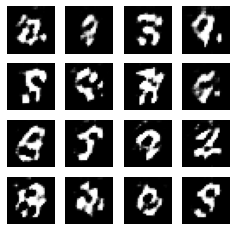

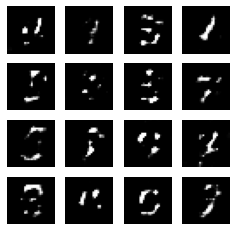

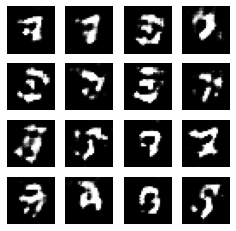

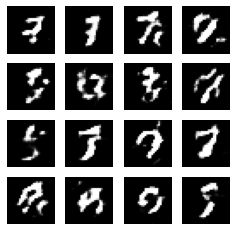

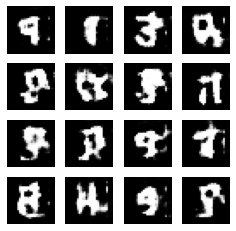

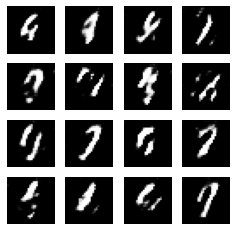

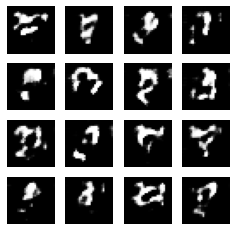

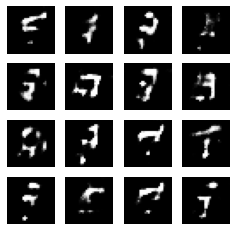

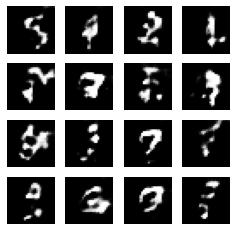

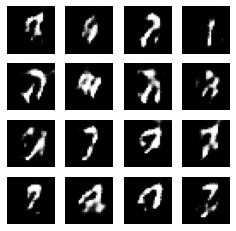

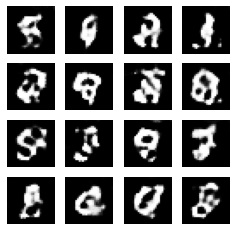

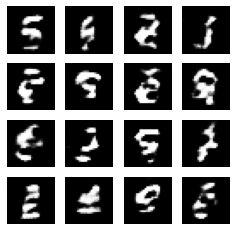

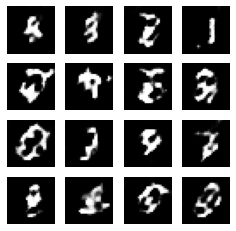

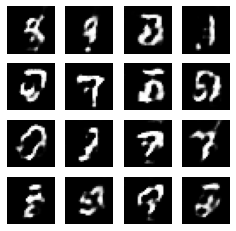

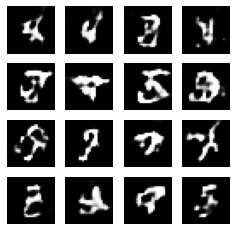

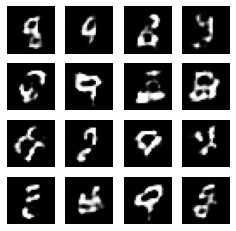

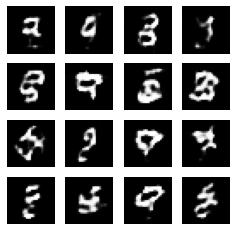

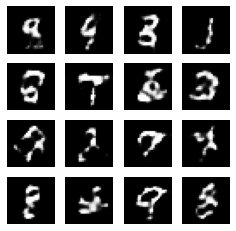

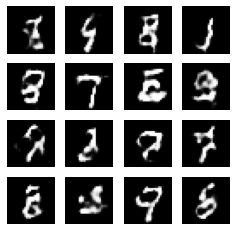

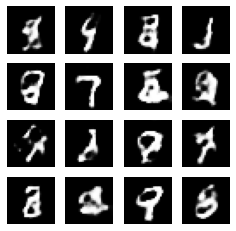

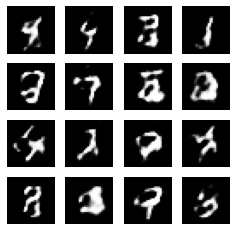

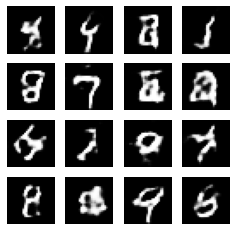

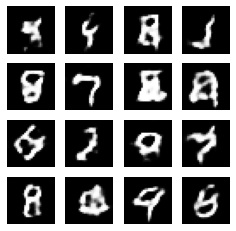

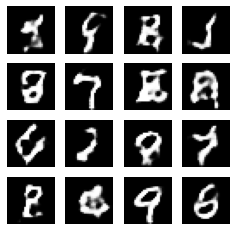

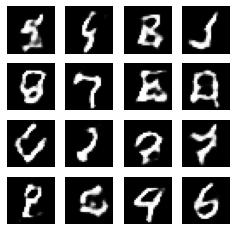

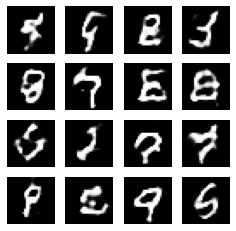

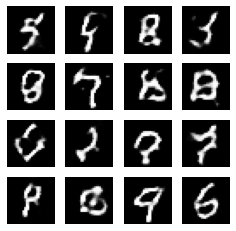

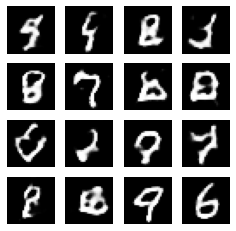

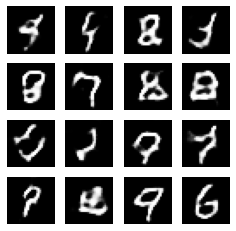

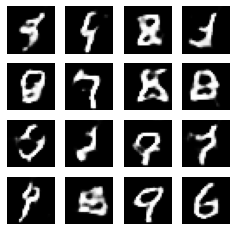

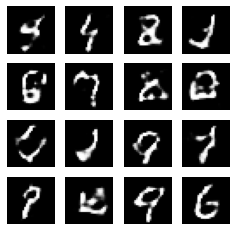

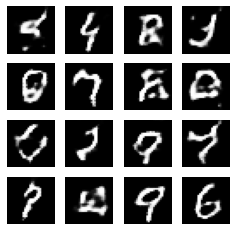

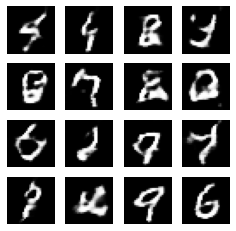

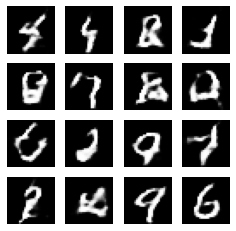

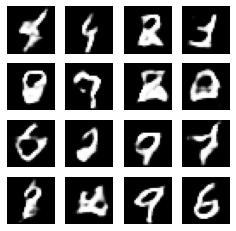

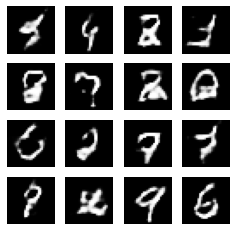

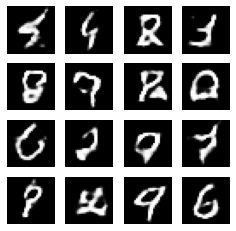

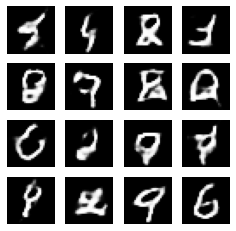

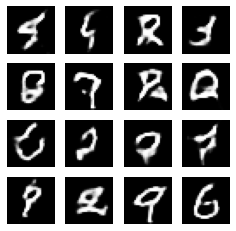

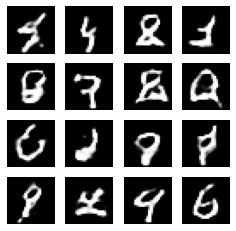

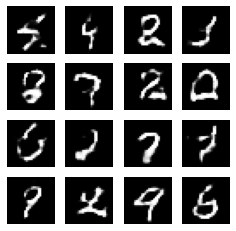

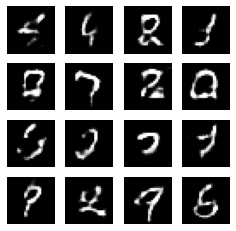

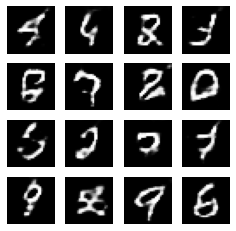

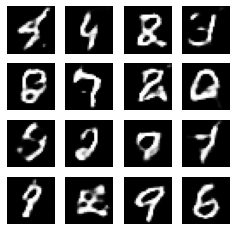

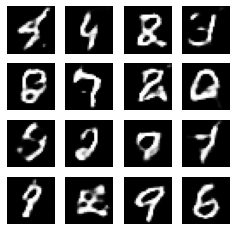

In [39]:
train(train_dataset, EPOCHS)

### after all epochs it will generate almost similar to real images